# Cassava Leaf Disease Classification - EDA

- toc: true
- badges: true
- categories: [plant,disease,classification,eda]


In [22]:
#collapse-hide
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
import albumentations as A 
from pylab import rcParams
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os, gc, cv2, random, warnings, math, sys, json, pprint
from pathlib import Path
Path.ls = lambda x: list(x.iterdir())
import altair as alt

# sklearn
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# tf 
import tensorflow as tf
from tensorflow.keras import backend as K

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.simplefilter('ignore')

In [42]:
#collapse-hide
# helper function to plot sample 
def plot_imgs(dataset_show, iters):
    rcParams['figure.figsize'] = 20,10
    for i in range(iters):
        f, ax = plt.subplots(1,5)
        for p in range(5):
            idx = np.random.randint(0, len(dataset_show))
            img, label = dataset_show[idx]
            ax[p].grid(False)
            ax[p].imshow(img[0])
            ax[p].set_title(idx)
    plt.show()
    

def visualize(path, n_images, is_random=True, figsize=(16, 16)):
    plt.figure(figsize=figsize)
    
    w = int(n_images ** .5)
    h = math.ceil(n_images / w)
    
    image_names = path.ls()
    for i in range(n_images):
        image_name = random.choice(image_names) if is_random else image_name[i];
        img = cv2.imread(str(image_name))
        plt.subplot(h, w, i + 1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.show()  

In [35]:
#hide
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [13]:
class BaseConfig(object):
  SEED  = 101
  PROJECT_PATH = Path('/content/gdrive/MyDrive/1_AUSTIN CHEN/Data Scientist/Datasets/cassava-leaf-disease-classification')
  TRAIN_DF       = PROJECT_PATH/'train.csv'
  TRAIN_IMG_PATH = PROJECT_PATH/'train_images/'
  TEST_IMG_PATH  = PROJECT_PATH/'test_images/'
  CLASS_MAP      = PROJECT_PATH/'label_num_to_disease_map.json'

In [14]:
df = pd.read_csv(BaseConfig.TRAIN_DF)
df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [15]:
assert(len(df.image_id) == len(df.image_id.unique()), "NOT ALL ID UNIQUE")

In [16]:
with open(str(BaseConfig.CLASS_MAP)) as file:
  id2label = json.loads(file.read())

In [18]:
id2label

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [19]:
temp_df = df.copy()
temp_df[list(id2label.values())] = pd.get_dummies(temp_df["label"])

In [20]:
fig = go.Figure(
    data=[go.Pie(labels=temp_df.columns[2:],
                 values=temp_df.iloc[:,2:].sum().values)])
fig.show()

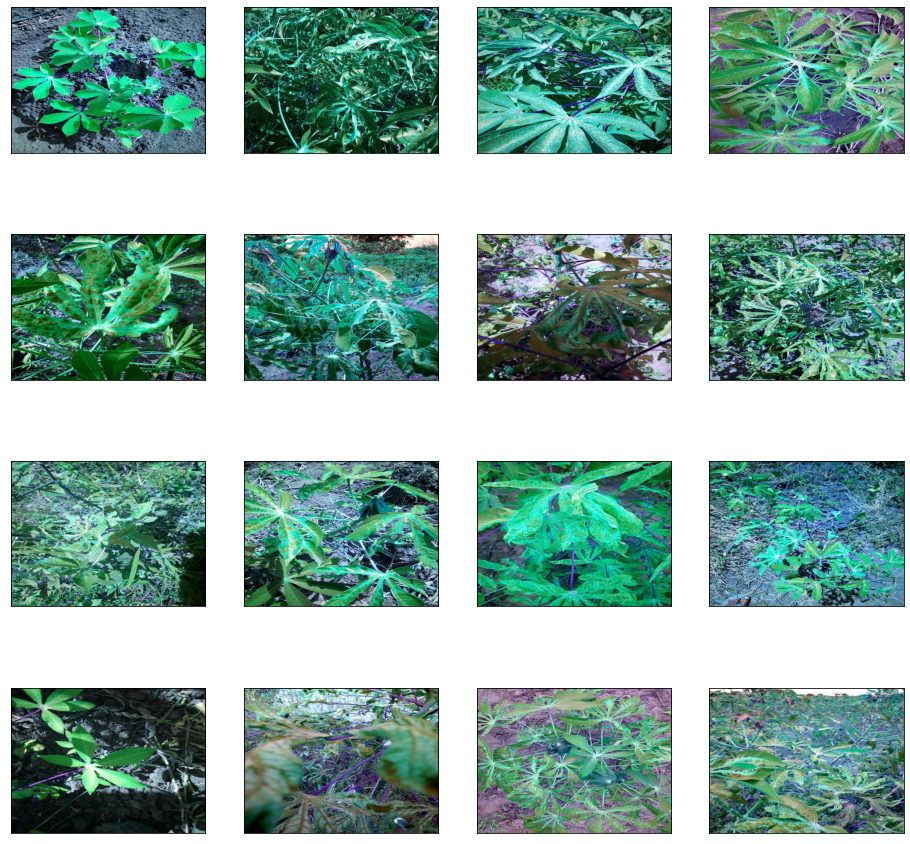

In [45]:
visualize(BaseConfig.TRAIN_IMG_PATH, 16, is_random=True)

# Augmentation

The `albumentation` is primarily used for resizing and normalization.

In [46]:
# For Training 
def albu_transforms_train(data_resize): 
    return A.Compose([
            A.ToFloat(),
            A.Resize(data_resize, data_resize),
        ], p=1.)

# For Validation 
def albu_transforms_valid(data_resize): 
    return A.Compose([
            A.ToFloat(),
            A.Resize(data_resize, data_resize),
        ], p=1.)

In [47]:
def CutMix(image, label, DIM, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    CLASSES = 5
    
    imgs = []; labs = []
    for j in range(len(image)):
        # DO CUTMIX WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)
        
        # CHOOSE RANDOM IMAGE TO CUTMIX WITH
        k = tf.cast( tf.random.uniform([],0,len(image)),tf.int32)
        
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        
        b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
        
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)

        # MAKE CUTMIX IMAGE
        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)
        
        # MAKE CUTMIX LABEL
        a = tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
        labs.append((1-a)*label[j] + a*label[k])
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(len(image),DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(len(image),CLASSES))
    
    return image2,label2

In [48]:
def MixUp(image, label, DIM, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with mixup applied
    CLASSES = 5
    
    imgs = []; labs = []
    for j in range(len(image)):
        # DO MIXUP WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.float32)
                   
        # CHOOSE RANDOM
        k = tf.cast( tf.random.uniform([],0,len(image)),tf.int32)
        a = tf.random.uniform([],0,1)*P # this is beta dist with alpha=1.0
                    
        # MAKE MIXUP IMAGE
        img1 = image[j,]
        img2 = image[k,]
        imgs.append((1-a)*img1 + a*img2)
                    
        # MAKE CUTMIX LABEL
        labs.append((1-a)*label[j] + a*label[k])
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(len(image),DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(len(image),CLASSES))
    return image2,label2

# Custom Data Generator

In [65]:
import pdb

In [82]:
class CassavaGenerator(tf.keras.utils.Sequence):
  def __init__(self, path, data, bs, dim, shuffle=True, tfm=None,
               use_mixup=False, use_cutmix=False, use_fmix=False):
    self.path = path
    self.data = data
    self.bs = bs
    self.dim = dim
    self.shuffle = shuffle
    self.augment = tfm
    self.use_mixup = use_mixup
    self.use_cutmix = use_cutmix
    self.use_fmix = use_fmix
    self.list_idx = self.data.index.values
    self.label = pd.get_dummies(self.data['label'], columns=['label'])
    self.on_epoch_end()
  
  def __len__(self):
    return int(np.ceil(float(len(self.data)) / float(self.bs)))

  def __getitem__(self, index):
    #start = index * self.bs
    #end = (index+1) * self.bs
    #batch_ids = self.indices[start:end]

    batch_idx = self.indices[index*self.bs:(index+1)*self.bs]
    idx = [self.list_idx[k] for k in batch_idx]

    xs = np.empty((self.bs, *self.dim))
    ys = np.empty((self.bs, 5), dtype=np.float32)

    for i,k in enumerate(idx):
      #pdb.set_trace()
      image = cv2.imread(f"{self.path}/{self.data['image_id'][k]}")
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      augmented = self.augment(image=image)
      image = augmented['image']

      xs[i, :, :, :] = image
      ys[i, :] = self.label.loc[k, :].values

      if self.use_cutmix:
        xs, ys = CutMix(xs, ys, self.dim[0])
        
      if self.use_mixup:
        xs, ys = MixUp(xs, ys, self.dim[0])

      if self.use_fmix:
        xs,  ys = FMix(xs, ys, self.dim[0])
    
    return xs, ys

  def on_epoch_end(self):
    self.indices = np.arange(len(self.list_idx))
    if self.shuffle: np.random.shuffle(self.indices)
  

In [ ]:
def plot_imgs(dataset_show, iters):
    rcParams['figure.figsize'] = 20,10
    for i in range(iters):
        f, ax = plt.subplots(1,5)
        for p in range(5):
            idx = np.random.randint(0, len(dataset_show))
            img, label = dataset_show[idx]
            ax[p].grid(False)
            ax[p].imshow(img[0])
            ax[p].set_title(idx)
    plt.show()


In [83]:
dg = CassavaGenerator(BaseConfig.TRAIN_IMG_PATH, df, 20, (128,128,3), shuffle=True,
                 use_mixup=False, use_cutmix=True, use_fmix=False,
                 tfm=albu_transforms_train(128))

In [84]:
dg[0]

TypeError: ignored

# Moving to the next 1% improvement

1. Fix the `TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment` error and figure why there is a difference between Kaggle and Colab.